# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
ecom_data_df = pd.read_parquet("../dataset/processed/olist_ecom_cleaned.parquet")

In [3]:
ecom_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7475 entries, 0 to 7474
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    7475 non-null   object        
 1   customer_unique_id             7475 non-null   object        
 2   customer_zip_code_prefix       6877 non-null   float64       
 3   customer_city                  7475 non-null   object        
 4   customer_state                 7475 non-null   object        
 5   order_id                       7475 non-null   object        
 6   order_status                   7475 non-null   object        
 7   order_purchase_timestamp       7475 non-null   datetime64[ns]
 8   order_approved_at              7475 non-null   datetime64[ns]
 9   order_delivered_carrier_date   7409 non-null   datetime64[ns]
 10  order_delivered_customer_date  7405 non-null   datetime64[ns]
 11  order_estimated_d

In [4]:
print(ecom_data_df.dtypes)

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                float64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
payment_sequential                      float64
payment_type                             object
payment_installments                    float64
payment_value                           float64
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   

Change data type 'customer_zip_code_prefix' to object

In [5]:
print(
    f"data type before replace the data type: {ecom_data_df['customer_zip_code_prefix'].dtype}"
)

# change the data type
ecom_data_df["customer_zip_code_prefix"] = ecom_data_df[
    "customer_zip_code_prefix"
].astype(object)

print(
    f"data type after replace the data type: {ecom_data_df['customer_zip_code_prefix'].dtype}"
)

data type before replace the data type: float64
data type after replace the data type: object


## Make feature base time

In [6]:
def calculate_duration(df, start_date_col, end_date_col, unit="days"):
    """
    calculate two column date durration in preferred unit
    Args:
        df (pd.DataFrame): DataFrame input.
        start_date_col (str): start column name.
        end_date_col (str): end column name.
        unit (str): unit preferred('days', 'hours', 'seconds').

    Returns:
        pd.Series: result durration that contains calculations.
                   return NaN if wrong or onf of NaT input dates.
    """
    # calculate timedelta (time gap)
    duration_timedelta = df[end_date_col] - df[start_date_col]

    # convert timedelta to total second time
    duration_seconds = duration_timedelta.dt.total_seconds()

    # convert total second time to preferred unit
    if unit == "seconds":
        return duration_seconds
    elif unit == "hours":
        return duration_seconds / 3600
    elif unit == "days":
        return duration_seconds / (24 * 3600)

    else:
        raise ValueError(
            f"unit is not supported: {unit}. choose 'days', 'hours', 'seconds'."
        )

In [7]:
# Define the specifications for each duration calculation
# Each tuple contains: (new_column_name, start_date_column, end_date_column)
duration_specs = [
    ("time_to_approve", "order_purchase_timestamp", "order_approved_at"),
    ("time_to_carrier", "order_approved_at", "order_delivered_carrier_date"),
    ("shipping_time", "order_delivered_carrier_date", "order_delivered_customer_date"),
    (
        "total_delivery_time",
        "order_purchase_timestamp",
        "order_delivered_customer_date",
    ),
    (
        "delivery_vs_estimate",
        "order_estimated_delivery_date",
        "order_delivered_customer_date",
    ),
]

# Define the unit for all calculations (assuming it's the same for now)
calculation_unit = "days"

print(f"--- Creating Time-Based Features (Unit: {calculation_unit}) ---")

# Loop through the specifications and calculate/assign the duration for each
for new_col_name, start_col, end_col in duration_specs:
    if start_col in ecom_data_df.columns and end_col in ecom_data_df.columns:
        ecom_data_df[new_col_name] = calculate_duration(
            ecom_data_df, start_col, end_col, calculation_unit
        )
        print(f"Created column: '{new_col_name}'")
    else:
        print(
            f"Warning: Skipping '{new_col_name}'. Start column '{start_col}' or end column '{end_col}' not found."
        )

print(
    f"Columns created:\n{[col for col in ecom_data_df.columns if col in [spec[0] for spec in duration_specs]]}"
)
print("Time-based features creation complete!")

--- Creating Time-Based Features (Unit: days) ---
Created column: 'time_to_approve'
Created column: 'time_to_carrier'
Created column: 'shipping_time'
Created column: 'total_delivery_time'
Created column: 'delivery_vs_estimate'
Columns created:
['time_to_approve', 'time_to_carrier', 'shipping_time', 'total_delivery_time', 'delivery_vs_estimate']
Time-based features creation complete!


## Investigate Order-Payment Relationship & Create Order Level (Non-Payment) Feature

In [8]:
print("-- Investigate relations order-payment --")

# Count how many rows for each order_id
order_id_counts = ecom_data_df["order_id"].value_counts()

# identification order_id that appears more than once (orders with multi-item or multi-payment)
multiple_rows_order_ids = order_id_counts[order_id_counts > 1].index.tolist()

print(f"unique number of order_id: {len(order_id_counts)}")
print(f"total order_id with multiple rows: {len(multiple_rows_order_ids)}")

if multiple_rows_order_ids:
    sample_order_id = multiple_rows_order_ids[0]
    print(
        f"Payment details for sample order_id with multiple rows ({sample_order_id}):"
    )
    display(
        ecom_data_df[ecom_data_df["order_id"] == sample_order_id][
            [
                "order_id",
                "payment_sequential",
                "payment_type",
                "payment_installments",
                "payment_value",
                "price",
                "freight_value",
            ]
        ].head()
    )
    print(f"total number of multiple rows: {len(ecom_data_df[ecom_data_df["order_id"] == sample_order_id])}")
else:
    print(
        "No order_id with multiple rows was found in the DataFrame (after this cleanup)."
    )

-- Investigate relations order-payment --
unique number of order_id: 6817
total order_id with multiple rows: 465
Payment details for sample order_id with multiple rows (465c2e1bee4561cb39e0db8c5993aafc):


,order_id,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value
2095,465c2e1bee4561cb39e0db8c5993aafc,8.0,voucher,1.0,41.03,412.0,27.72
2096,465c2e1bee4561cb39e0db8c5993aafc,8.0,voucher,1.0,41.03,412.0,27.72
2097,465c2e1bee4561cb39e0db8c5993aafc,4.0,voucher,1.0,59.40,412.0,27.72
2098,465c2e1bee4561cb39e0db8c5993aafc,4.0,voucher,1.0,59.40,412.0,27.72
2099,465c2e1bee4561cb39e0db8c5993aafc,2.0,voucher,1.0,26.18,412.0,27.72


total number of multiple rows: 12


## Make feature level Comprehensif Order

In [9]:
# Aggregate data from level item/payment to level order_id
order_level_features_df = (
    ecom_data_df.groupby("order_id")
    .agg(
        # moneter feature
        total_payment_value=("payment_value", "sum"),
        total_item_price=("price", "sum"),
        total_freight_value=("freight_value", "sum"),
        # item/product feature
        number_of_rows_in_orders=("order_item_id", "count"),
        number_of_unique_products=("product_id", lambda x: x.nunique()),
        # payment feature
        max_payment_sequential=("payment_sequential", "max"),
        number_of_unique_payment_types=("payment_type", lambda x: x.nunique()),
        max_payment_installments=("payment_installments", "max"),
    )
    .reset_index()
)

In [10]:
if isinstance(order_level_features_df, pd.DataFrame):
    print("Verification: The created object is indeed a pandas DataFrame.")
    display(order_level_features_df.head())
    print(order_level_features_df.info())
else:
    print("Verification Warning: The created object is NOT a pandas DataFrame.")

Verification: The created object is indeed a pandas DataFrame.


,order_id,total_payment_value,total_item_price,total_freight_value,number_of_rows_in_orders,number_of_unique_products,max_payment_sequential,number_of_unique_payment_types,max_payment_installments
0,0011d82c4b53e22e84023405fb467e57,315.33,289.0,26.33,1,1,1.0,1,2.0
1,00229e4e43f7a7e0b9dd819ad43268d3,91.39,74.9,16.49,1,1,1.0,1,1.0
2,002b4e6fa42cd4a22cc86abc18fe9c05,119.57,99.9,19.67,1,1,1.0,1,2.0
3,00345f338696283410b7977d2e3efc89,67.34,48.9,18.44,1,1,1.0,1,1.0
4,003d0634280ff3d1d3a54459349a6899,228.89,220.0,8.89,1,1,1.0,1,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6817 entries, 0 to 6816
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   order_id                        6817 non-null   object 
 1   total_payment_value             6817 non-null   float64
 2   total_item_price                6817 non-null   float64
 3   total_freight_value             6817 non-null   float64
 4   number_of_rows_in_orders        6817 non-null   int64  
 5   number_of_unique_products       6817 non-null   int64  
 6   max_payment_sequential          6817 non-null   float64
 7   number_of_unique_payment_types  6817 non-null   int64  
 8   max_payment_installments        6817 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 479.4+ KB
None


## RFM Analysis

In [11]:
order_customer_mapping = ecom_data_df[
    ["order_id", "customer_unique_id"]
].drop_duplicates()

# merge mapping using 'order_id'
order_level_features_df = pd.merge(
    order_level_features_df, order_customer_mapping, how="left", on="order_id"
)

if isinstance(order_level_features_df, pd.DataFrame):
    print("Verification: The created object is indeed a pandas DataFrame.")
    display(
        order_level_features_df[
            ["order_id", "customer_unique_id", "total_payment_value"]
        ].head()
    )
else:
    print("Verification Warning: The created object is NOT a pandas DataFrame.")

Verification: The created object is indeed a pandas DataFrame.


,order_id,customer_unique_id,total_payment_value
0,0011d82c4b53e22e84023405fb467e57,02daaa0e021d624d1784c4ea5cc84ace,315.33
1,00229e4e43f7a7e0b9dd819ad43268d3,12d280dc9e8bf7888a3d2a8a8ae74f8d,91.39
2,002b4e6fa42cd4a22cc86abc18fe9c05,248d18ee4a4b0977fd21ef3273eb4352,119.57
3,00345f338696283410b7977d2e3efc89,93b592cbb89abbda7dc554c39add344e,67.34
4,003d0634280ff3d1d3a54459349a6899,2fe9477037604b2d6f60ffc998eb0812,228.89


Calculate Frequency (F) and Monetary (M) per customer

In [12]:
# aggregate dataframe 'order_level_features_df' base 'customer_unique_id'
customer_rfm_fm_df = (
    order_level_features_df.groupby("customer_unique_id")
    .agg(
        frequency=("order_id", "count"),
        monetary=("total_payment_value", "sum"),
    )
    .reset_index()
)

In [13]:
if isinstance(customer_rfm_fm_df, pd.DataFrame):
    print("Verification: The created object is indeed a pandas DataFrame.")
    display(customer_rfm_fm_df.head())
    print(customer_rfm_fm_df.info())
else:
    print("Verification Warning: The created object is NOT a pandas DataFrame.")

Verification: The created object is indeed a pandas DataFrame.


,customer_unique_id,frequency,monetary
0,001147e649a7b1afd577e873841632dd,1,0.00
1,0015752e079902b12cd00b9b7596276b,1,0.00
2,00293787e2aec37a9c253b63fdfe2049,1,257.87
3,002d3bd901608f67c3fc11eaaa842b13,1,28.76
4,003fb95e849e71e732629d94bb92762f,1,77.59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6798 entries, 0 to 6797
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  6798 non-null   object 
 1   frequency           6798 non-null   int64  
 2   monetary            6798 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 159.5+ KB
None


identify Snapshot Date Recency

In [14]:
latest_order_date = ecom_data_df["order_purchase_timestamp"].max()
print(f"latest order date: {latest_order_date}")

latest order date: 2018-09-09 14:42:05


Set Final Date Recency

In [15]:
snaphot_date = latest_order_date + pd.Timedelta(days=1)
print(f"snapshot date recency: {snaphot_date}")

snapshot date recency: 2018-09-10 14:42:05


Identify Last Order Date per Customer

In [16]:
latest_order_per_customer = (
    ecom_data_df.groupby("customer_unique_id")["order_purchase_timestamp"]
    .max()
    .reset_index()
)

Calculate Recency (R)

calculate the difference between days `snapshot_date` and the date of their last order `latest_order_per_customer`.

In [17]:
latest_order_per_customer["Recency"] = (
    snaphot_date - latest_order_per_customer["order_purchase_timestamp"]
).dt.days

# change data type 'Recency' from object to number
latest_order_per_customer["Recency"] = latest_order_per_customer["Recency"].astype(int)

In [18]:
display(latest_order_per_customer.head())
print(latest_order_per_customer.info())

,customer_unique_id,order_purchase_timestamp,Recency
0,001147e649a7b1afd577e873841632dd,2017-08-30 14:02:49,376
1,0015752e079902b12cd00b9b7596276b,2018-08-02 18:23:51,38
2,00293787e2aec37a9c253b63fdfe2049,2017-10-25 16:44:50,319
3,002d3bd901608f67c3fc11eaaa842b13,2018-01-17 14:09:01,236
4,003fb95e849e71e732629d94bb92762f,2018-07-29 07:39:37,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6798 entries, 0 to 6797
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        6798 non-null   object        
 1   order_purchase_timestamp  6798 non-null   datetime64[ns]
 2   Recency                   6798 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 159.5+ KB
None


Merge Recency to RFM DataFrame

In [19]:
customer_rfm_final_df = pd.merge(
    customer_rfm_fm_df,
    latest_order_per_customer[["customer_unique_id", "Recency"]],
    on="customer_unique_id",
    how="left",
)

In [20]:
customer_rfm_final_df.head()

,customer_unique_id,frequency,monetary,Recency
0,001147e649a7b1afd577e873841632dd,1,0.00,376
1,0015752e079902b12cd00b9b7596276b,1,0.00,38
2,00293787e2aec37a9c253b63fdfe2049,1,257.87,319
3,002d3bd901608f67c3fc11eaaa842b13,1,28.76,236
4,003fb95e849e71e732629d94bb92762f,1,77.59,43


Replace name rfm with standard naming 'Rencency', 'Monetary', 'Frequency'

In [21]:
customer_rfm_final_df.rename(
    columns={"frequency": "Frequency", "monetary": "Monetary"}, inplace=True
)

In [22]:
display(customer_rfm_final_df[["Frequency", "Monetary", "Recency"]].head())
display(customer_rfm_final_df.describe())
display(customer_rfm_final_df.info())

,Frequency,Monetary,Recency
0,1,0.00,376
1,1,0.00,38
2,1,257.87,319
3,1,28.76,236
4,1,77.59,43


,Frequency,Monetary,Recency
count,6798.000000,6798.000000,6798.000000
mean,1.002795,189.250038,250.852751
std,0.052797,373.730931,153.443822
min,1.000000,0.000000,1.000000
25%,1.000000,58.387500,126.000000
50%,1.000000,106.040000,231.000000
75%,1.000000,189.145000,359.000000
max,2.000000,11200.200000,705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6798 entries, 0 to 6797
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  6798 non-null   object 
 1   Frequency           6798 non-null   int64  
 2   Monetary            6798 non-null   float64
 3   Recency             6798 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 212.6+ KB


None

Define number quantile **RFM** score & calculate score **Recency**

In [23]:
num_quantiles = 5

customer_rfm_final_df["R_score"] = pd.qcut(
    customer_rfm_final_df["Recency"], q=num_quantiles, labels=False, duplicates="drop"
)

customer_rfm_final_df["R_score"] = num_quantiles - customer_rfm_final_df["R_score"]

In [24]:
print(f"Recency score: {num_quantiles}")
display(customer_rfm_final_df[["customer_unique_id", "Recency", "R_score"]].head())

# check distribution
print(customer_rfm_final_df["R_score"].value_counts().sort_index())

Recency score: 5


,customer_unique_id,Recency,R_score
0,001147e649a7b1afd577e873841632dd,376,2
1,0015752e079902b12cd00b9b7596276b,38,5
2,00293787e2aec37a9c253b63fdfe2049,319,2
3,002d3bd901608f67c3fc11eaaa842b13,236,3
4,003fb95e849e71e732629d94bb92762f,43,5


R_score
1    1352
2    1362
3    1365
4    1352
5    1367
Name: count, dtype: int64


Calculate limit quantile & give score for **Frequency**

In [25]:
print(f"Attempting to assign Frequency score using {num_quantiles} quantiles...")

# --- Attempt scoring using pd.qcut ---
customer_rfm_final_df["F_score"] = pd.qcut(
    customer_rfm_final_df["Frequency"],
    q=num_quantiles,
    labels=False,
    duplicates="drop",
)

# Add 1 to shift the scores from 1 to q.
customer_rfm_final_df["F_score"] = customer_rfm_final_df["F_score"] + 1

# --- Step 2: Check if the quantile scoring resulted in a "skewed" distribution ---
# We check if the number of unique scores produced is less than the requested number of quantiles.
# If it is, it indicates that pd.qcut couldn't create distinct quantiles due to skewness/duplicates.

if customer_rfm_final_df["F_score"].nunique() < num_quantiles:
    print(
        f"\nWarning: Quantile scoring for Frequency resulted in only {customer_rfm_final_df['F_score'].nunique()} unique scores (less than {num_quantiles})."
    )
    print("This indicates a highly skewed distribution preventing distinct quantiles.")
    print("Proceeding with alternative manual scoring based on unique values.")

    # --- Step 3: If skewed, apply manual scoring based on unique values ---
    # This is the logic that was originally in the 'except' block.
    # It assigns score 1 if Frequency is exactly 1, otherwise assigns score 2.
    # Make sure this logic fits your definition of manual scoring based on skewness.

    customer_rfm_final_df["F_score"] = customer_rfm_final_df["Frequency"].apply(
        lambda x: 1 if x == 1 else 2
    )
    print("Manual scoring applied successfully.")

else:
    # --- Step 4: If not skewed (unique scores == num_quantiles), the quantile scoring is considered good ---
    print("\nQuantile scoring resulted in the expected number of unique scores.")
    print("Quantile scoring is considered successful.")

Attempting to assign Frequency score using 5 quantiles...

This indicates a highly skewed distribution preventing distinct quantiles.
Proceeding with alternative manual scoring based on unique values.
Manual scoring applied successfully.


In [26]:
print(f"Recency score: {num_quantiles}")
display(customer_rfm_final_df[["customer_unique_id", "Recency", "F_score"]].head())

# check distribution
print(customer_rfm_final_df["F_score"].value_counts().sort_index())

Recency score: 5


,customer_unique_id,Recency,F_score
0,001147e649a7b1afd577e873841632dd,376,1
1,0015752e079902b12cd00b9b7596276b,38,1
2,00293787e2aec37a9c253b63fdfe2049,319,1
3,002d3bd901608f67c3fc11eaaa842b13,236,1
4,003fb95e849e71e732629d94bb92762f,43,1


F_score
1    6779
2      19
Name: count, dtype: int64


Calculate limit quantile & give score for Monetary

In [27]:
print(f"Attempting to assign Monetary score using {num_quantiles} quantiles...")

# --- Attempt scoring using pd.qcut ---
customer_rfm_final_df["M_score"] = pd.qcut(
    customer_rfm_final_df["Monetary"],
    q=num_quantiles,
    labels=False,
    duplicates="drop",
)

# Add 1 to shift the scores from 1 to q.
customer_rfm_final_df["M_score"] = customer_rfm_final_df["M_score"] + 1

# --- Step 2: Check if the quantile scoring resulted in a "skewed" distribution ---
# We check if the number of unique scores produced is less than the requested number of quantiles.
# If it is, it indicates that pd.qcut couldn't create distinct quantiles due to skewness/duplicates.

if customer_rfm_final_df["M_score"].nunique() < num_quantiles:
    print(
        f"\nWarning: Quantile scoring for Monetary resulted in only {customer_rfm_final_df['M_score'].nunique()} unique scores (less than {num_quantiles})."
    )
    print("This indicates a highly skewed distribution preventing distinct quantiles.")
    print("Proceeding with alternative manual scoring based on unique values.")

    # --- Step 3: If skewed, apply manual scoring based on unique values ---
    # This is the logic that was originally in the 'except' block.
    # It assigns score 1 if Monetary is exactly 1, otherwise assigns score 2.
    # Make sure this logic fits your definition of manual scoring based on skewness.

    customer_rfm_final_df["M_score"] = customer_rfm_final_df["Monetary"].apply(
        lambda x: 1 if x == 1 else 2
    )
    print("Manual scoring applied successfully.")

else:
    # --- Step 4: If not skewed (unique scores == num_quantiles), the quantile scoring is considered good ---
    print("\nQuantile scoring resulted in the expected number of unique scores.")
    print("Quantile scoring is considered successful.")

Attempting to assign Monetary score using 5 quantiles...

Quantile scoring resulted in the expected number of unique scores.
Quantile scoring is considered successful.


In [28]:
print(f"Monetary score: {num_quantiles}")
display(customer_rfm_final_df[["customer_unique_id", "Monetary", "M_score"]].head())

# check distribution
print(customer_rfm_final_df["M_score"].value_counts().sort_index())

Monetary score: 5


,customer_unique_id,Monetary,M_score
0,001147e649a7b1afd577e873841632dd,0.00,1
1,0015752e079902b12cd00b9b7596276b,0.00,1
2,00293787e2aec37a9c253b63fdfe2049,257.87,5
3,002d3bd901608f67c3fc11eaaa842b13,28.76,1
4,003fb95e849e71e732629d94bb92762f,77.59,2


M_score
1    1361
2    1358
3    1360
4    1359
5    1360
Name: count, dtype: int64


In [29]:
# combine RFM score

customer_rfm_final_df["RFM_score_string"] = (
    customer_rfm_final_df["R_score"].astype(int).astype(str)
    + customer_rfm_final_df["F_score"].astype(int).astype(str)
    + customer_rfm_final_df["M_score"].astype(int).astype(str)
)

# make RFM score composite
customer_rfm_final_df["RFM_score_composite"] = (
    customer_rfm_final_df["R_score"]
    + customer_rfm_final_df["F_score"]
    + customer_rfm_final_df["M_score"]
)

In [30]:
display(
    customer_rfm_final_df[
        ["customer_unique_id", "R_score", "F_score", "M_score", "RFM_score_string"]
    ].head()
)

,customer_unique_id,R_score,F_score,M_score,RFM_score_string
0,001147e649a7b1afd577e873841632dd,2,1,1,211
1,0015752e079902b12cd00b9b7596276b,5,1,1,511
2,00293787e2aec37a9c253b63fdfe2049,2,1,5,215
3,002d3bd901608f67c3fc11eaaa842b13,3,1,1,311
4,003fb95e849e71e732629d94bb92762f,5,1,2,512


In [31]:
display(
    customer_rfm_final_df[
        [
            "customer_unique_id",
            "R_score",
            "F_score",
            "M_score",
            "RFM_score_string",
            "RFM_score_composite",
        ]
    ].head()
)
display(
    customer_rfm_final_df[
        [
            "customer_unique_id",
            "R_score",
            "F_score",
            "M_score",
            "RFM_score_string",
            "RFM_score_composite",
        ]
    ].describe()
)
print(customer_rfm_final_df.info())

,customer_unique_id,R_score,F_score,M_score,RFM_score_string,RFM_score_composite
0,001147e649a7b1afd577e873841632dd,2,1,1,211,4
1,0015752e079902b12cd00b9b7596276b,5,1,1,511,7
2,00293787e2aec37a9c253b63fdfe2049,2,1,5,215,8
3,002d3bd901608f67c3fc11eaaa842b13,3,1,1,311,5
4,003fb95e849e71e732629d94bb92762f,5,1,2,512,8


,R_score,F_score,M_score,RFM_score_composite
count,6798.000000,6798.000000,6798.000000,6798.000000
mean,3.002942,1.002795,2.999853,7.005590
std,1.414002,0.052797,1.414578,1.994984
min,1.000000,1.000000,1.000000,3.000000
25%,2.000000,1.000000,2.000000,6.000000
50%,3.000000,1.000000,3.000000,7.000000
75%,4.000000,1.000000,4.000000,8.000000
max,5.000000,2.000000,5.000000,12.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6798 entries, 0 to 6797
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_unique_id   6798 non-null   object 
 1   Frequency            6798 non-null   int64  
 2   Monetary             6798 non-null   float64
 3   Recency              6798 non-null   int64  
 4   R_score              6798 non-null   int64  
 5   F_score              6798 non-null   int64  
 6   M_score              6798 non-null   int64  
 7   RFM_score_string     6798 non-null   object 
 8   RFM_score_composite  6798 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 478.1+ KB
None


Define RFM Segmentation Strategy

In [32]:
def assign_rfm_segment(row):
    """
    Assigns an RFM customer segment based on R_score, F_score, and M_score
    using a rule-based approach for better readability and maintainability.

    Args:
        row (pd.Series): A row from the DataFrame containing 'R_score',
                         'F_score', and 'M_score'.

    Returns:
        str: The assigned RFM segment label.
             Returns "Undefined Segment" if no rule matches (should not happen
             if rules cover all score combinations).
    """
    # Extract scores for easier use
    R = row["R_score"]
    F = row["F_score"]
    M = row["M_score"]

    # Define the segmentation rules as a list of (condition, segment_label) tuples.
    segmentation_rules = [
        # F == 2 (Repeat Buyers)
        (lambda r, f, m: f == 2 and r >= 4 and m >= 4, "Repeat Buyers (Champions)"),
        (
            lambda r, f, m: f == 2 and r >= 4 and m < 4,
            "Repeat Buyers (Recent & Moderate/Low M)",
        ),
        (
            lambda r, f, m: f == 2 and r < 4 and m >= 4,
            "Repeat Buyers (Less Recent & High M)",
        ),
        (
            lambda r, f, m: f == 2 and r < 4 and m < 4,
            "Repeat Buyers (Less Recent & Moderate/Low M)",
        ),
        # F == 1 (Single Buyers)
        (
            lambda r, f, m: f == 1 and r >= 4 and m >= 4,
            "Single Buyers (High Value & Recent)",
        ),
        (
            lambda r, f, m: f == 1 and r >= 4 and m < 4,
            "Single Buyers (Recent & Moderate/Low M)",
        ),
        (
            lambda r, f, m: f == 1 and r >= 2 and r < 4 and m >= 4,
            "Single Buyers (Moderate R & High M)",
        ),
        (
            lambda r, f, m: f == 1 and r >= 2 and r < 4 and m < 4,
            "Single Buyers (Moderate R & Moderate/Low M)",
        ),
        (
            lambda r, f, m: f == 1 and r < 2 and m >= 4,
            "Single Buyers (Hibernating & High M)",
        ),
        (
            lambda r, f, m: f == 1 and r < 2 and m < 4,
            "Single Buyers (Hibernating & Moderate/Low M)",
        ),
    ]

    # Iterate through the rules and return the segment label for the first matching condition
    for condition, segment_label in segmentation_rules:
        if condition(R, F, M):
            return segment_label

    # Return a default label if no condition matches (should ideally not happen
    # if all score combinations are covered by the rules based on the original logic)
    return "Undefined Segment"

In [33]:
# apply function
customer_rfm_final_df["RFM_segment"] = customer_rfm_final_df.apply(
    assign_rfm_segment, axis=1
)

In [34]:
display(
    customer_rfm_final_df[
        [
            "customer_unique_id",
            "R_score",
            "F_score",
            "M_score",
            "RFM_score_string",
            "RFM_segment",
        ]
    ].head()
)

,customer_unique_id,R_score,F_score,M_score,RFM_score_string,RFM_segment
0,001147e649a7b1afd577e873841632dd,2,1,1,211,Single Buyers (Moderate R & Moderate/Low M)
1,0015752e079902b12cd00b9b7596276b,5,1,1,511,Single Buyers (Recent & Moderate/Low M)
2,00293787e2aec37a9c253b63fdfe2049,2,1,5,215,Single Buyers (Moderate R & High M)
3,002d3bd901608f67c3fc11eaaa842b13,3,1,1,311,Single Buyers (Moderate R & Moderate/Low M)
4,003fb95e849e71e732629d94bb92762f,5,1,2,512,Single Buyers (Recent & Moderate/Low M)


Calculate & make a Visualization for `RFM_segment` size

In [35]:
segment_size = customer_rfm_final_df["RFM_segment"].value_counts().reset_index()

# make columns
segment_size.columns = ["RFM_segment", "customer_count"]

/tmp/ipykernel_7964/1625178886.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


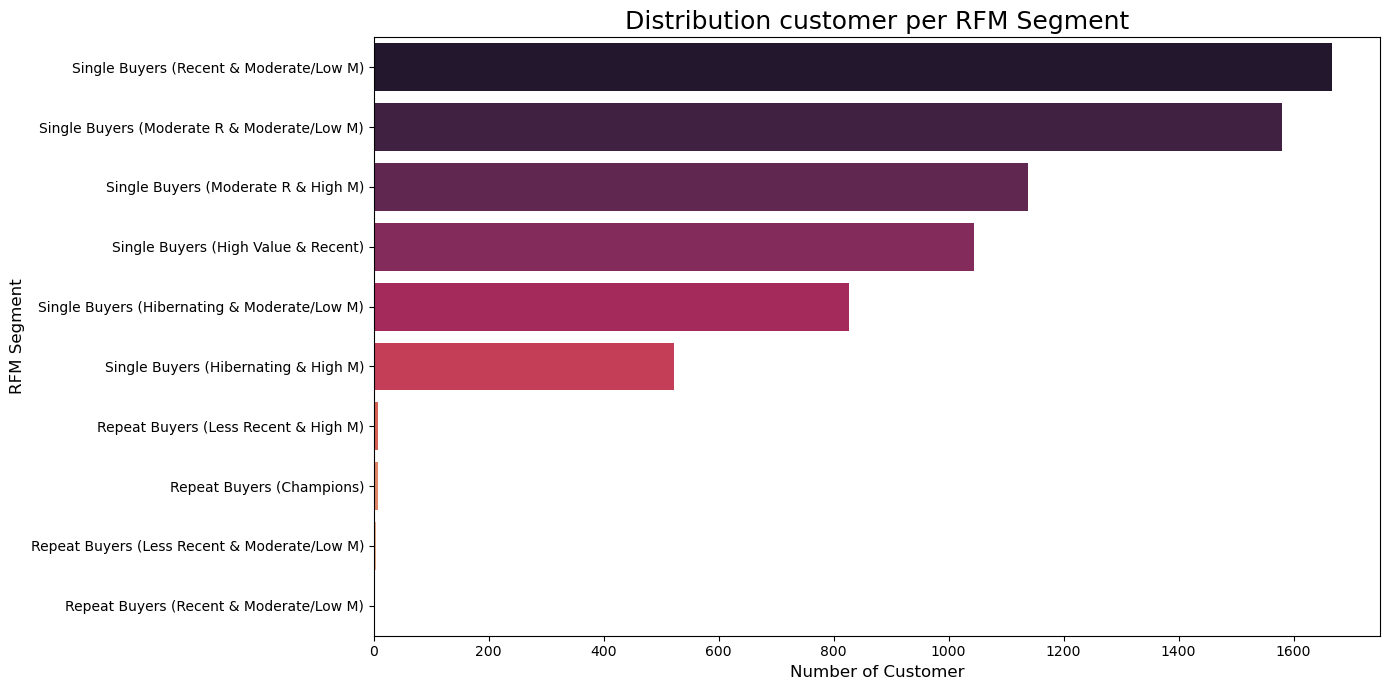

In [44]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x="customer_count",
    y="RFM_segment",
    data=segment_size.sort_values("customer_count", ascending=False),
    palette="rocket",
)

plt.title("Distribution customer per RFM Segment", fontsize=18)
plt.xlabel("Number of Customer", fontsize=12)
plt.ylabel("RFM Segment", fontsize=12)
plt.tight_layout()
plt.show()

Characterization of RFM Segments (Average Score & Original Value)

In [37]:
segment_characteristics = (
    customer_rfm_final_df.groupby("RFM_segment")
    .agg(
        Avg_R_score=("R_score", "mean"),
        Avg_F_score=("F_score", "mean"),
        Avg_M_score=("M_score", "mean"),
        Avg_Recency=("Recency", "mean"),
        Avg_Frequency=("Frequency", "mean"),
        Avg_Monetary=("Monetary", "mean"),
        Num_Customers=("customer_unique_id", "nunique"),
    )
    .round(2)
)

In [38]:
# sort the result base number of customer (use DESC)
segment_characteristics = segment_characteristics.sort_values(
    "Num_Customers", ascending=False
)

In [39]:
print("Result after characterization RFM segments\n")
display(segment_characteristics)

Result after characterization RFM segments



,Avg_R_score,Avg_F_score,Avg_M_score,Avg_Recency,Avg_Frequency,Avg_Monetary,Num_Customers
RFM_segment,,,,,,,
Single Buyers (Recent & Moderate/Low M),4.51,1.0,2.03,101.80,1.0,69.05,1667
Single Buyers (Moderate R & Moderate/Low M),2.49,1.0,1.97,282.38,1.0,66.88,1580
Single Buyers (Moderate R & High M),2.51,1.0,4.48,280.31,1.0,383.71,1138
Single Buyers (High Value & Recent),4.50,1.0,4.49,103.30,1.0,359.21,1044
Single Buyers (Hibernating & Moderate/Low M),1.00,1.0,1.99,487.33,1.0,67.71,827
Single Buyers (Hibernating & High M),1.00,1.0,4.55,488.48,1.0,368.08,523
Repeat Buyers (Champions),4.29,2.0,4.57,110.71,2.0,361.89,7
Repeat Buyers (Less Recent & High M),2.57,2.0,4.86,271.71,2.0,363.77,7
Repeat Buyers (Less Recent & Moderate/Low M),2.25,2.0,2.75,332.75,2.0,94.58,4


Average RFM Score visualization per Segment

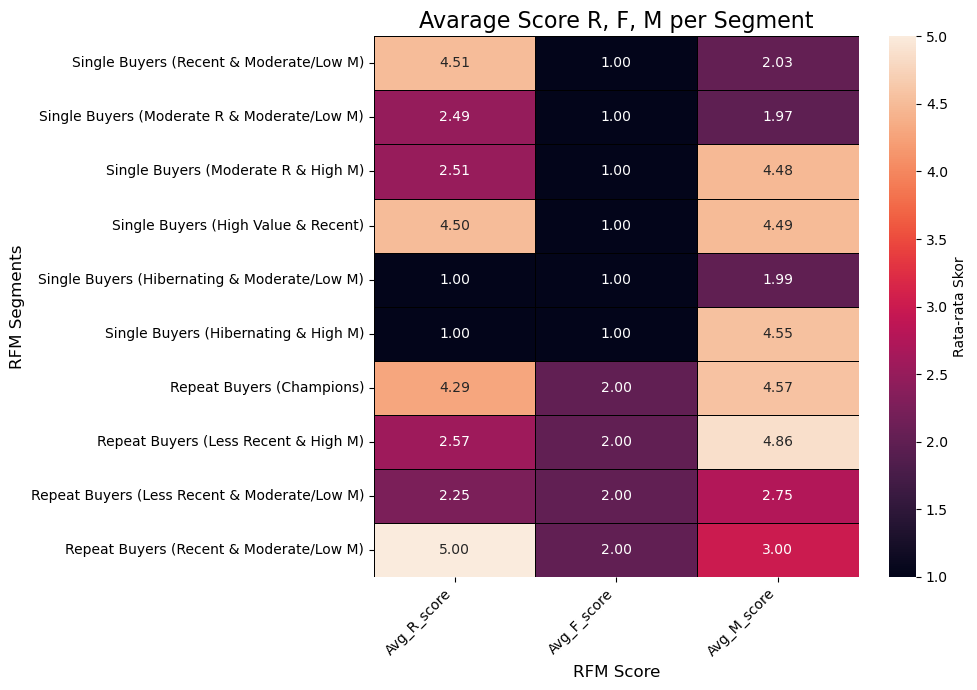

In [43]:
scores_for_heatmap = segment_characteristics[
    [
        "Avg_R_score",
        "Avg_F_score",
        "Avg_M_score",
    ]
]

plt.figure(figsize=(10, 7))
sns.heatmap(
    scores_for_heatmap,
    annot=True,
    cmap="rocket",
    fmt=".2f",
    linewidths=0.5,
    linecolor="black",
    cbar_kws={"label": "Rata-rata Skor"},
)

plt.title("Avarage Score R, F, M per Segment", fontsize=16)
plt.xlabel("RFM Score", fontsize=12)
plt.ylabel("RFM Segments", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Identify product or category products that most bought by customer

In [45]:
# merge data to get product categories per customer_unique_id and RFM segment

product_info_df = ecom_data_df[
    ["customer_unique_id", "order_id", "product_id", "product_category_name"]
].copy()

# drop duplicate
product_info_df.drop_duplicates(inplace=True)

# merge data
df_segment_products = pd.merge(
    customer_rfm_final_df, product_info_df, how="left", on="customer_unique_id"
)

# drop rows without product categries
df_segment_products.dropna(subset=["product_category_name"], inplace=True)

In [47]:
# count the number of times a product category appears per segment
product_preference_per_segment = (
    df_segment_products.groupby(["RFM_segment", "product_category_name"])
    .size()
    .reset_index(name="order_count")
)

In [57]:
# for every segment, get 5 higher category product
top_n = 5
top_products_per_segment = (
    product_preference_per_segment.sort_values(
        ["RFM_segment", "order_count"], ascending=[True, False]
    )
    .groupby("RFM_segment")
    .head(top_n)
    .reset_index(drop=True)
)

Identify most city/state per segment

In [54]:
df_segment_geo = pd.merge(
    customer_rfm_final_df,
    ecom_data_df[["customer_unique_id", "customer_city", "customer_state"]],
    on="customer_unique_id",
    how="left",
)

df_segment_geo.dropna(subset=["customer_city", "customer_state"], inplace=True)

In [ ]:
# calculate number of unique customer per segment
geo_distribution_per_segment_city = (
    df_segment_geo.groupby(["RFM_segment", "customer_city"])["customer_unique_id"]
    .nunique()
    .reset_index(name="customer_count")
)
geo_distribution_per_segment_state = (
    df_segment_geo.groupby(["RFM_segment", "customer_state"])["customer_unique_id"]
    .nunique()
    .reset_index(name="customer_count")
)

In [58]:
# Take the top 5 cities/states per segment
top_n = 5
top_cities_per_segment = (
    geo_distribution_per_segment_city.sort_values(
        ["RFM_segment", "customer_count"], ascending=[True, False]
    )
    .groupby("RFM_segment")
    .head(top_n)
    .reset_index(drop=True)
)

top_states_per_segment = (
    geo_distribution_per_segment_state.sort_values(
        ["RFM_segment", "customer_count"], ascending=[True, False]
    )
    .groupby("RFM_segment")
    .head(top_n)
    .reset_index(drop=True)
)